In [1]:
import torch
from torch_geometric.loader import DataLoader
from sklearn.model_selection  import train_test_split

from tools.utils import *
from tools.hom_networks import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
# Random
seed = 42

# Model
hidden_channels = 128
num_classes = 7
num_layers = 2
aggr='mean'
dropout = 0.5

# Training
batch_size = 32
epochs = 30
lr = 1e-4
maxlr = 3e-4

# Preprocessing

In [3]:
reset_seeds(seed, device)

# CUDA reproducibility
if device.type == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Load dataset
hom_dataset = torch.load('data/PSCDB/hom_pscdb_graphs.pt', weights_only=False)
len(hom_dataset)

856

In [5]:
# Use edge_index_union as edge_index for Homo GNNs
def create_edge_index(data):
    data = data.clone()
    if hasattr(data, 'edge_index_union') and data['edge_index_union'] is not None:
        data['edge_index'] = data['edge_index_union']
        data.pop('edge_index_free', None)
        data.pop('edge_index_bound', None)
        data.pop('pos_free', None)
        data.pop('pos_bound', None)
        data.pop('edge_index_union', None)
    return data

hom_dataset_reindexed = [create_edge_index(hom_data) for hom_data in hom_dataset]

In [6]:
def normalize_enzymes_data(data):
    data = data.clone()
    if hasattr(data, 'x') and data.x is not None:
        x = data.x
        # Normalize free and bound coordinates
        coords = x[:, 20:26]
        mean = coords.mean(dim=0)
        std = coords.std(dim=0, unbiased=False)
        std[std == 0] = 1.0
        normalized_coords = (coords - mean) / std
        x[:, 20:26] = normalized_coords
        # Recompute displacement as (bound_normalized - free_normalized)
        free_normalized = normalized_coords[:, :3]
        bound_normalized = normalized_coords[:, 3:6]
        displacement_normalized = bound_normalized - free_normalized
        x[:, 26:29] = displacement_normalized
        data.x = x
    return data

# Normalize features
normalized_hom_dataset = [normalize_enzymes_data(hom_data) for hom_data in hom_dataset_reindexed]

In [7]:
# Create splits
labels = [data.y.item() for data in normalized_hom_dataset]

train_set, temp_set = train_test_split(
    normalized_hom_dataset, 
    test_size=0.3, 
    stratify=labels,
    random_state=seed
    
)

temp_labels = [data.y.item() for data in temp_set]
valid_set, test_set = train_test_split(
    temp_set, 
    test_size=0.5, 
    stratify=temp_labels,
    random_state=seed
)

# train_loader is defined at each experiment for reproducibility
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# HomoGNN_GraphConv

In [8]:
experiment_name = f"PSCDB-HomoGNN_GraphConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GraphConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GraphConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GraphConv((-1, -1), 128)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [9]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [10]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.9464 | Validation Loss: 1.9445
Train Acc: 0.0718 | Validation Acc: 0.0703
Train F1: 0.0191 | Validation F1: 0.0188

Epoch 2/30
Train Loss: 1.9430 | Validation Loss: 1.9400
Train Acc: 0.0718 | Validation Acc: 0.1328
Train F1: 0.0192 | Validation F1: 0.0737

Epoch 3/30
Train Loss: 1.9355 | Validation Loss: 1.9284
Train Acc: 0.3205 | Validation Acc: 0.3438
Train F1: 0.0897 | Validation F1: 0.0731

Epoch 4/30
Train Loss: 1.9102 | Validation Loss: 1.8834
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 5/30
Train Loss: 1.8332 | Validation Loss: 1.8151
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 6/30
Train Loss: 1.8054 | Validation Loss: 1.8011
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 7/30
Train Loss: 1.7958 | Validation Loss: 1.8040
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 8/30
Tr

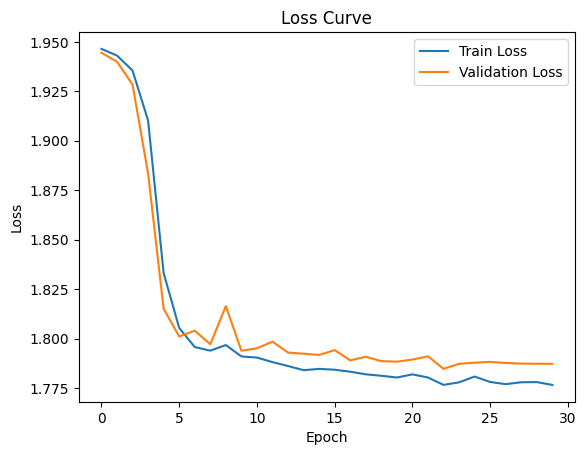

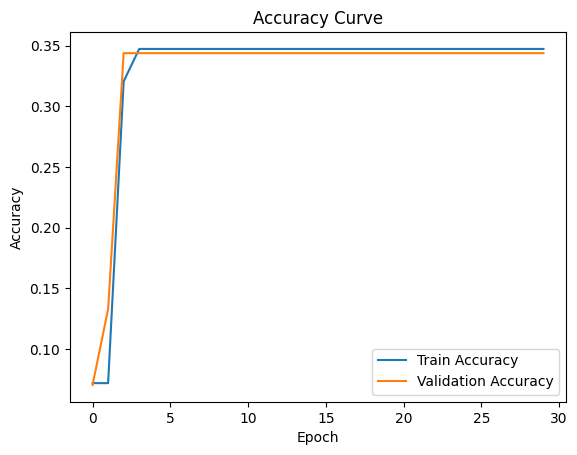

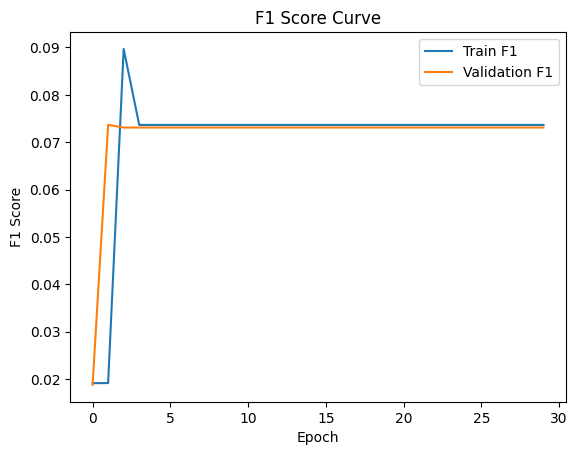

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.9464,1.9445,0.0718,0.0703,0.0191,0.0188
1,2,1.9430,1.9400,0.0718,0.1328,0.0192,0.0737
2,3,1.9355,1.9284,0.3205,0.3438,0.0897,0.0731
3,4,1.9102,1.8834,0.3472,0.3438,0.0736,0.0731
4,5,1.8332,1.8151,0.3472,0.3438,0.0736,0.0731
5,6,1.8054,1.8011,0.3472,0.3438,0.0736,0.0731
6,7,1.7958,1.8040,0.3472,0.3438,0.0736,0.0731
7,8,1.7940,1.7972,0.3472,0.3438,0.0736,0.0731
8,9,1.7968,1.8164,0.3472,0.3438,0.0736,0.0731
9,10,1.7910,1.7939,0.3472,0.3438,0.0736,0.0731


In [11]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HomoGNN_SAGEConv

In [12]:
experiment_name = f"PSCDB-HomoGNN_SAGEConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_SAGEConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_SAGEConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): SAGEConv((-1, -1), 128, aggr=mean)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [13]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [14]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.9464 | Validation Loss: 1.9445
Train Acc: 0.0718 | Validation Acc: 0.0703
Train F1: 0.0191 | Validation F1: 0.0188

Epoch 2/30
Train Loss: 1.9430 | Validation Loss: 1.9400
Train Acc: 0.0718 | Validation Acc: 0.1328
Train F1: 0.0192 | Validation F1: 0.0737

Epoch 3/30
Train Loss: 1.9355 | Validation Loss: 1.9284
Train Acc: 0.3205 | Validation Acc: 0.3438
Train F1: 0.0897 | Validation F1: 0.0731

Epoch 4/30
Train Loss: 1.9102 | Validation Loss: 1.8834
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 5/30
Train Loss: 1.8332 | Validation Loss: 1.8151
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 6/30
Train Loss: 1.8054 | Validation Loss: 1.8011
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 7/30
Train Loss: 1.7958 | Validation Loss: 1.8040
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 8/30
Tr

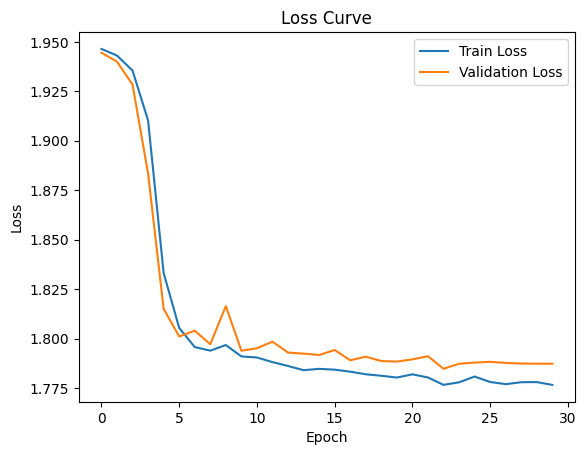

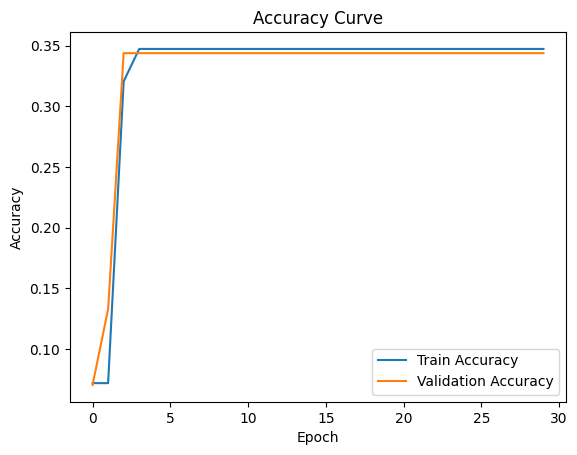

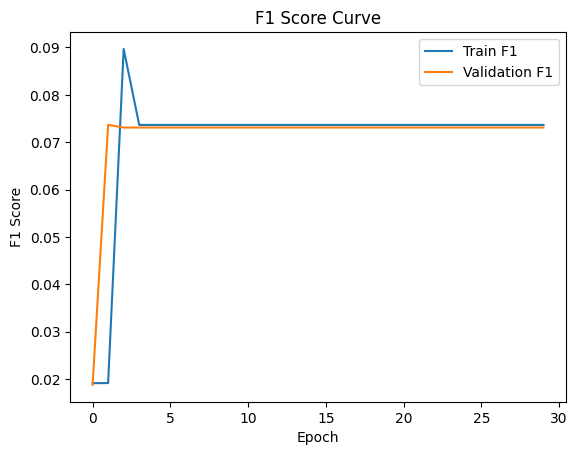

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.9464,1.9445,0.0718,0.0703,0.0191,0.0188
1,2,1.9430,1.9400,0.0718,0.1328,0.0192,0.0737
2,3,1.9355,1.9284,0.3205,0.3438,0.0897,0.0731
3,4,1.9102,1.8834,0.3472,0.3438,0.0736,0.0731
4,5,1.8332,1.8151,0.3472,0.3438,0.0736,0.0731
5,6,1.8054,1.8011,0.3472,0.3438,0.0736,0.0731
6,7,1.7958,1.8040,0.3472,0.3438,0.0736,0.0731
7,8,1.7940,1.7972,0.3472,0.3438,0.0736,0.0731
8,9,1.7968,1.8165,0.3472,0.3438,0.0736,0.0731
9,10,1.7910,1.7939,0.3472,0.3438,0.0736,0.0731


In [15]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)

# HomoGNN_GATConv

In [16]:
experiment_name = f"PSCDB-HomoGNN_GATConv-{hidden_channels} hidden channels-{num_layers} mlp-{num_layers} conv-{aggr} aggr-{dropout} dropout-{lr} lr-{maxlr} maxlr-OneCylceLR-Adam-CE Loss"

reset_seeds(seed, device)
train_loader = get_train_loader(seed, train_set, batch_size)
model = HomoGNN_GATConv(hidden_channels, num_classes, mlp_layers=num_layers, conv_layers=num_layers, aggr=aggr, dropout=dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
model

HomoGNN_GATConv(
  (node_emb_layers): ModuleList(
    (0): MLP(
      (layers): ModuleList(
        (0): Linear(-1, 128, bias=True)
        (1): Dropout(p=0.5, inplace=False)
        (2): Linear(128, 128, bias=True)
      )
    )
  )
  (conv_blocks): ModuleList(
    (0-1): 2 x ModuleDict(
      (conv): GATConv((-1, -1), 128, heads=1)
      (post_lin): MLP(
        (layers): ModuleList(
          (0): Linear(-1, 128, bias=True)
          (1): Dropout(p=0.5, inplace=False)
          (2): Linear(128, 128, bias=True)
        )
      )
    )
  )
  (classifier): Linear(128, 7, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [17]:
batches_per_epoch = len(train_loader)
total_steps = epochs * batches_per_epoch

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=maxlr, total_steps=total_steps, epochs=epochs, cycle_momentum=False)

In [18]:
metrics = {
    'train_loss': [],
    'valid_loss': [],
    'train_acc': [],
    'valid_acc': [],
    'train_f1': [],
    'valid_f1': []
}

for epoch in range(1, epochs+1):
    train_loss, train_acc, train_f1 = train(model, train_loader, optimizer, criterion, hom_predict, scheduler=scheduler, device=device)
    valid_loss, valid_acc, valid_f1 = test(model, valid_loader, criterion, hom_predict, device=device)
    
    # Update metrics
    metrics['train_loss'].append(train_loss)
    metrics['valid_loss'].append(valid_loss)
    metrics['train_acc'].append(train_acc)
    metrics['valid_acc'].append(valid_acc)
    metrics['train_f1'].append(train_f1)
    metrics['valid_f1'].append(valid_f1)
    
    print(f"Epoch {epoch}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f} | Validation Acc: {valid_acc:.4f}")
    print(f"Train F1: {train_f1:.4f} | Validation F1: {valid_f1:.4f}\n")

Epoch 1/30
Train Loss: 1.9624 | Validation Loss: 1.9610
Train Acc: 0.1169 | Validation Acc: 0.1172
Train F1: 0.0299 | Validation F1: 0.0300

Epoch 2/30
Train Loss: 1.9604 | Validation Loss: 1.9583
Train Acc: 0.1169 | Validation Acc: 0.1172
Train F1: 0.0299 | Validation F1: 0.0300

Epoch 3/30
Train Loss: 1.9565 | Validation Loss: 1.9525
Train Acc: 0.1169 | Validation Acc: 0.1172
Train F1: 0.0354 | Validation F1: 0.0300

Epoch 4/30
Train Loss: 1.9480 | Validation Loss: 1.9409
Train Acc: 0.1536 | Validation Acc: 0.1406
Train F1: 0.0601 | Validation F1: 0.0352

Epoch 5/30
Train Loss: 1.9228 | Validation Loss: 1.8819
Train Acc: 0.2654 | Validation Acc: 0.3438
Train F1: 0.0889 | Validation F1: 0.0731

Epoch 6/30
Train Loss: 1.8164 | Validation Loss: 1.7970
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 7/30
Train Loss: 1.7958 | Validation Loss: 1.7939
Train Acc: 0.3472 | Validation Acc: 0.3438
Train F1: 0.0736 | Validation F1: 0.0731

Epoch 8/30
Tr

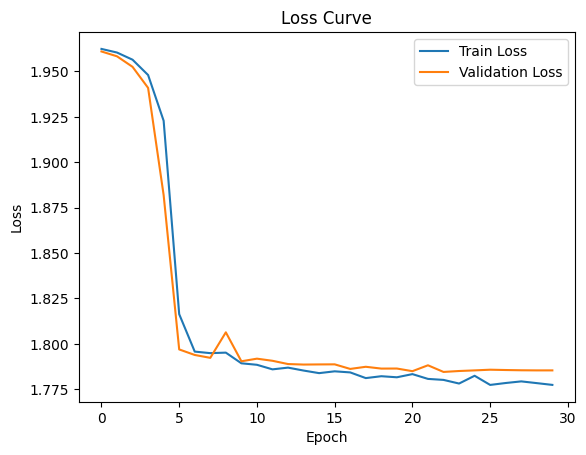

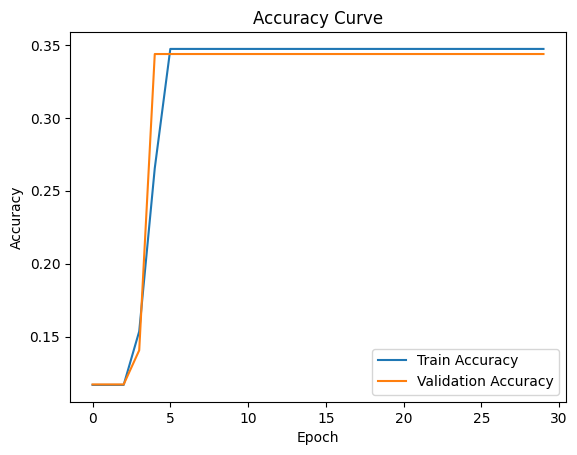

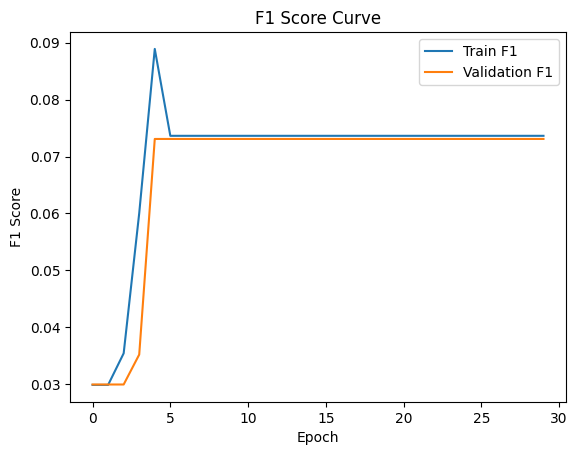

,Epoch,Train Loss,Valid Loss,Train Acc,Valid Acc,Train F1,Valid F1
0,1,1.9624,1.9610,0.1169,0.1172,0.0299,0.0300
1,2,1.9604,1.9583,0.1169,0.1172,0.0299,0.0300
2,3,1.9565,1.9525,0.1169,0.1172,0.0354,0.0300
3,4,1.9480,1.9409,0.1536,0.1406,0.0601,0.0352
4,5,1.9228,1.8819,0.2654,0.3438,0.0889,0.0731
5,6,1.8164,1.7970,0.3472,0.3438,0.0736,0.0731
6,7,1.7958,1.7939,0.3472,0.3438,0.0736,0.0731
7,8,1.7949,1.7923,0.3472,0.3438,0.0736,0.0731
8,9,1.7952,1.8064,0.3472,0.3438,0.0736,0.0731
9,10,1.7893,1.7904,0.3472,0.3438,0.0736,0.0731


In [19]:
plot_metrics(metrics, experiment_name)
create_metrics_table(metrics, experiment_name)